In [66]:
# TIME SERIES FORECASTING WITH ARIMA & SARIMAX

In [67]:
import pandas as pd
import yfinance as yf
import datetime

In [68]:
#Extract, Transform & Load

from datetime import date, timedelta
today = date.today()

d1 = today
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

#Collecting Latest Google stock price data using the Yahoo Finance API.

# Extracting Data
data = yf.download('GOOG', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]

# Transforming Data
data.reset_index(drop=True, inplace=True)
print(data.tail())

          Date        Open        High         Low       Close   Adj Close  \
224 2023-07-14  125.129997  127.089996  124.900002  125.699997  125.699997   
225 2023-07-17  126.059998  127.279999  124.500000  125.059998  125.059998   
226 2023-07-18  124.904999  124.989998  123.300003  124.080002  124.080002   
227 2023-07-19  124.790001  125.470001  122.470001  122.779999  122.779999   
228 2023-07-20  122.120003  124.699997  118.684998  119.529999  119.529999   

       Volume  
224  20482800  
225  20675300  
226  21071200  
227  22313800  
228  27541700  


In [69]:
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]

data.reset_index(drop=True, inplace=True)
print(data.tail())

     Date        Open        High         Low       Close   Adj Close  \
224   224  125.129997  127.089996  124.900002  125.699997  125.699997   
225   225  126.059998  127.279999  124.500000  125.059998  125.059998   
226   226  124.904999  124.989998  123.300003  124.080002  124.080002   
227   227  124.790001  125.470001  122.470001  122.779999  122.779999   
228   228  122.120003  124.699997  118.684998  119.529999  119.529999   

       Volume  
224  20482800  
225  20675300  
226  21071200  
227  22313800  
228  27541700  


In [70]:
# Loading Data
# For further analysis, We only need the date and close prices columns.

data = data[["Date", "Close"]]
print(data.head())

   Date       Close
0     0  115.070000
1     1  114.769997
2     2  114.699997
3     3  117.699997
4     4  111.300003


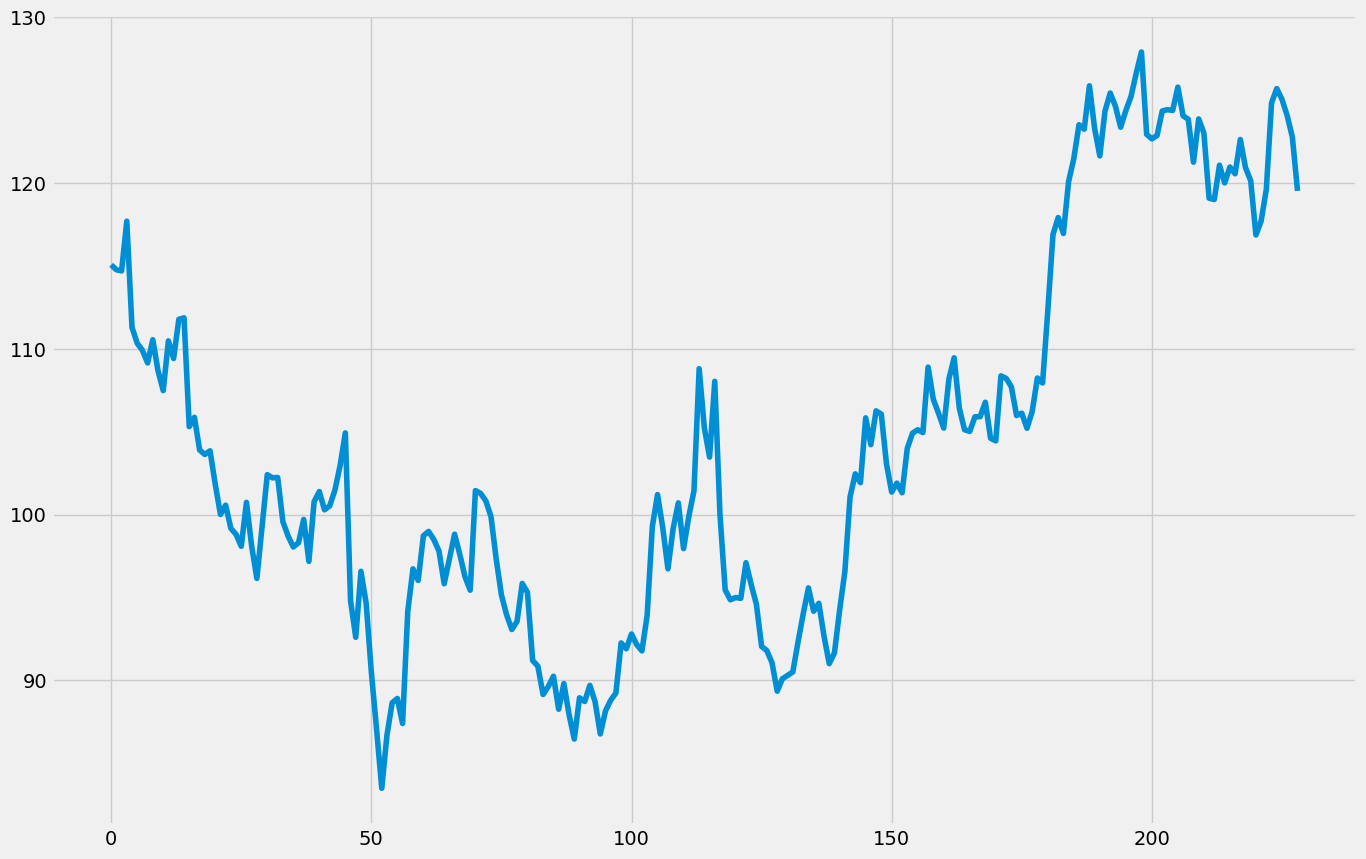

In [71]:
# Visualizing the close prices of Google 

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

In [72]:
# Data visualization graph about the closing stock prices shows that our dataset is not stationary.

# Thus, we need to check whether data is stationary or seasonal, For this we use seasonal decomposition

#Seasonal decomposition method splits the time series data into trend, seasonal, and residuals for a better understanding.

<Figure size 640x480 with 0 Axes>

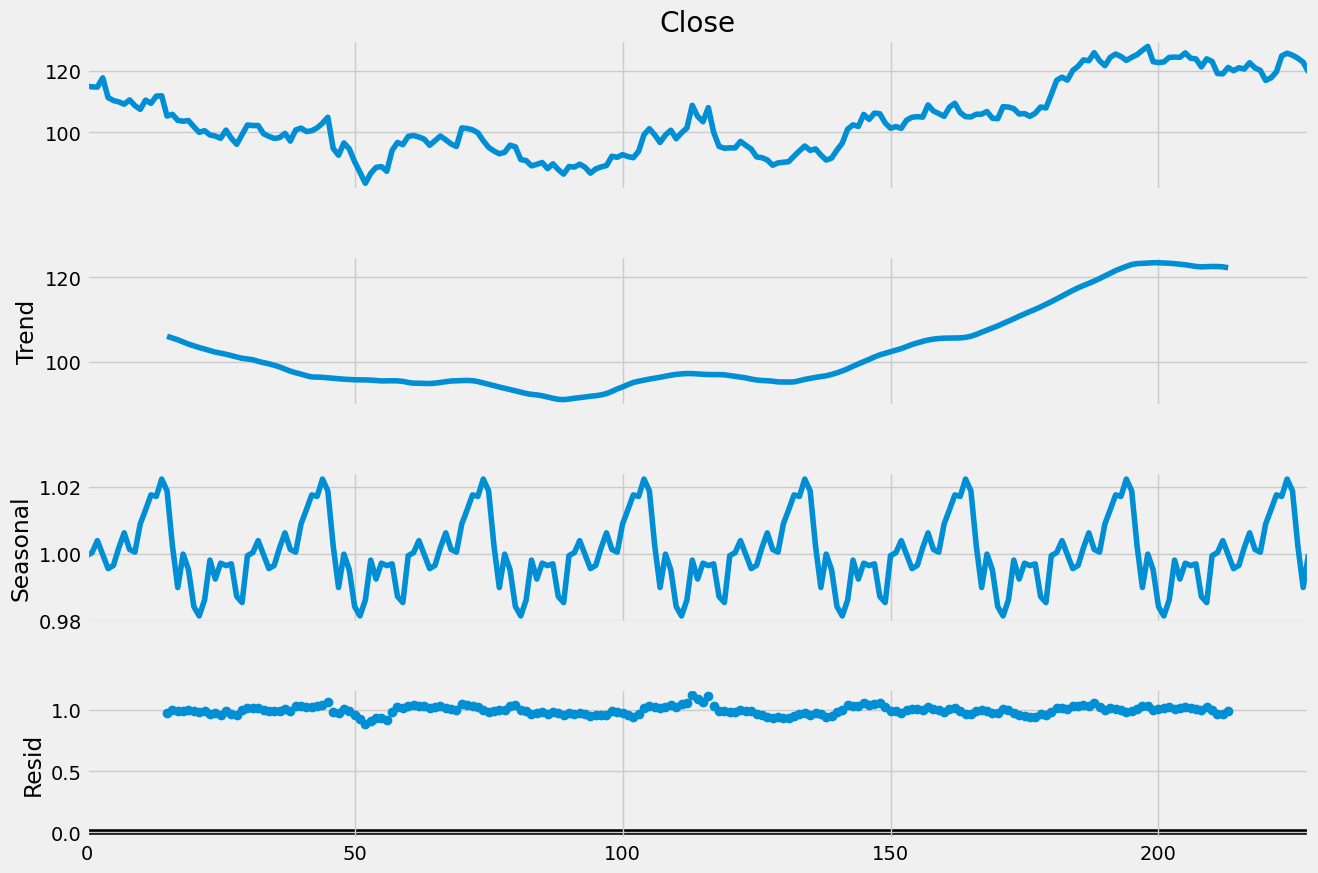

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], 
                            model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

In [122]:
#From above, we can see data is not stationary it is seasonal. 

# Thus Integrated part (d = 1). For stationary data, d = 0, seasonal data d = 1

#Thus, we need to use SARIMA, But let first check what results we get using ARIMA

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

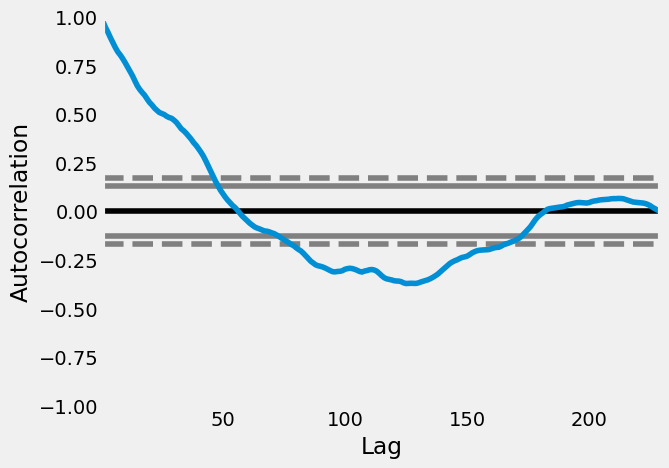

In [123]:
#Calculating p value 

# p is the number of lagged values that need to be added or subtracted from the values (label column).
# It captures the autoregressive part of ARIMA.
pd.plotting.autocorrelation_plot(data["Close"])

In [124]:
# In the above autocorrelation plot, p is 5

In [125]:
# Calculating Moving Average (q)
# q is the number of lagged values for the error term added or subtracted from the values (label column).

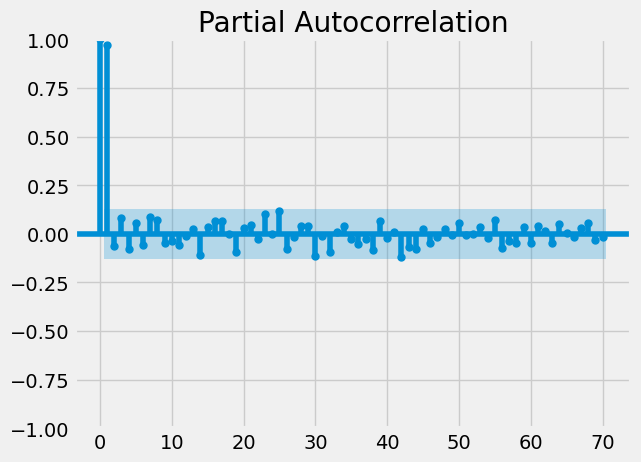

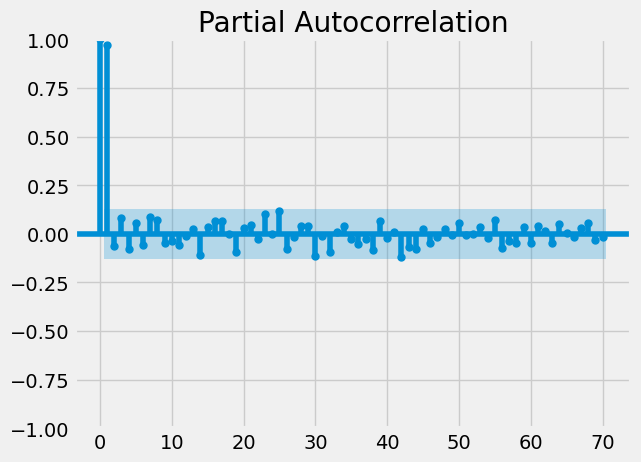

In [126]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags = 70)

In [127]:
# In the above partial autocorrelation plot, we can see only two points are far away from all the points. Hence the value of q is 2.

In [128]:
# Building ARIMA model

p, d, q = 5, 1, 2
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data["Close"], order=(p,d,q))  
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  229
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -510.712
Date:                Sun, 20 Aug 2023   AIC                           1037.423
Time:                        11:57:06   BIC                           1064.858
Sample:                             0   HQIC                          1048.493
                                - 229                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1715      0.070      2.462      0.014       0.035       0.308
ar.L2         -1.0961      0.081    -13.602      0.000      -1.254      -0.938
ar.L3          0.0981      0.104      0.941      0.3

In [131]:
# Predicting the values for stock for next 10 days using the ARIMA model

predictions = fitted.predict()
predictions = fitted.predict(len(data), len(data)+10)
print(predictions)

229    119.293050
230    119.909058
231    120.033588
232    119.633419
233    119.283318
234    119.587072
235    120.013532
236    119.773834
237    119.306307
238    119.471086
239    119.961476
Name: predicted_mean, dtype: float64


<Axes: >

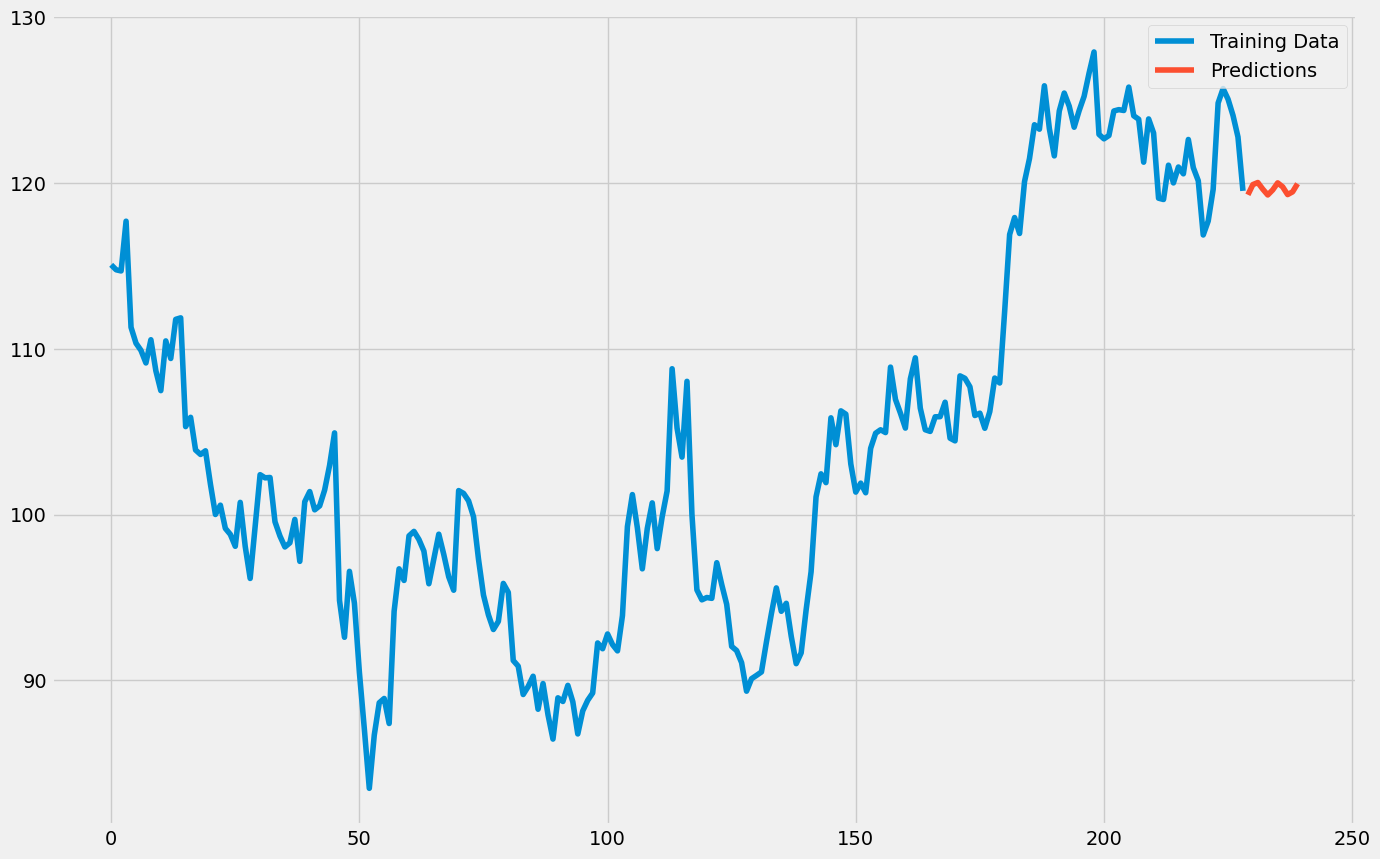

In [132]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")

In [133]:
# The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data

In [134]:
#Building SARIMAX Model

import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit(method="bfgs")
print(model.summary())

         Current function value: 2.231125
         Iterations: 3
         Function evaluations: 60
         Gradient evaluations: 48
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  229
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -510.928
Date:                            Sun, 20 Aug 2023   AIC                           1051.855
Time:                                    12:00:00   BIC                           1102.484
Sample:                                         0   HQIC                          1072.310
                                            - 229                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [135]:
# Let’s predict the future stock prices using the SARIMA model for the next 10 days

predictions = model.predict(len(data), len(data)+10)
print(predictions)

229    121.839573
230    122.741362
231    122.993788
232    124.627052
233    125.269513
234    126.052524
235    125.037449
236    125.416075
237    124.704121
238    125.466766
239    126.009023
Name: predicted_mean, dtype: float64


<Axes: >

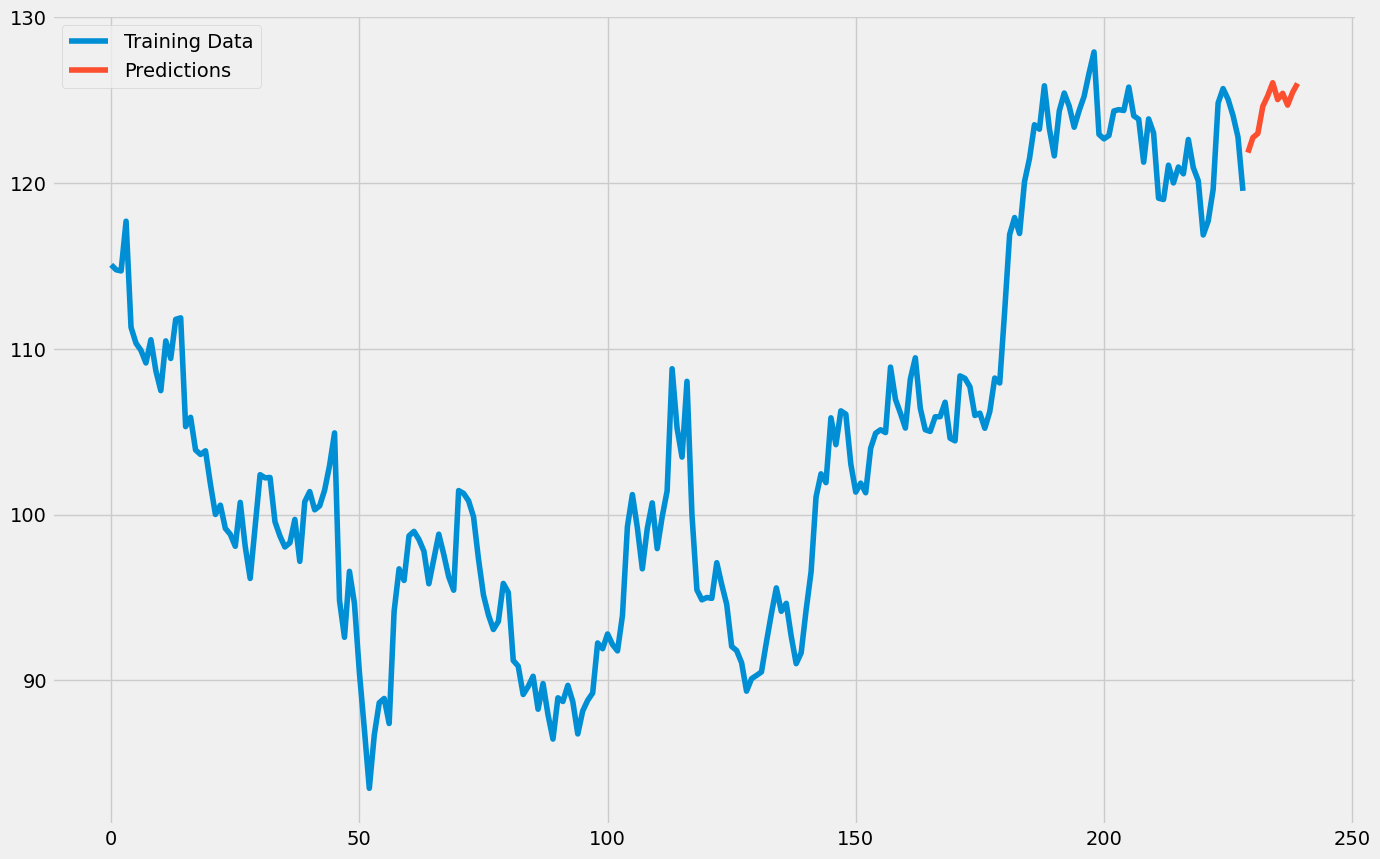

In [136]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")

In [137]:
# This SARIMA plot looks accurate.

#Thus, we can say, If the data is stationary, we need to use ARIMA, if the data is seasonal, we need to use Seasonal ARIMA (SARIMA)